In [148]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
df = pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')

In [150]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [151]:
customer_orders = df.groupby('Customer ID', as_index=False)['Order ID'].count()
customer_sales = df.groupby('Customer ID', as_index=False)['Sales'].sum()
customer_last_order = df.groupby('Customer ID', as_index=False)['Order Date'].max()
customer_last_order['Recency'] =  (df['Order Date'].max() - customer_last_order['Order Date']).dt.days

In [152]:
kdf = pd.merge(customer_orders, customer_sales, on='Customer ID')
kdf = pd.merge(kdf, customer_last_order, on='Customer ID').drop('Order Date', axis=1)
kdf.rename(columns={'Order ID': 'Frequency', 'Sales': 'Amount'}, inplace=True)
kdf

,Customer ID,Frequency,Amount,Recency
0,AA-10315,11,5563.560,184
1,AA-10375,15,1056.390,19
2,AA-10480,12,1790.512,259
3,AA-10645,18,5086.935,55
4,AB-10015,6,886.156,415
...,...,...,...,...
788,XP-21865,28,2374.658,43
789,YC-21895,8,5454.350,4
790,YS-21880,12,6720.444,9
791,ZC-21910,31,8025.707,54


In [153]:
color = ['#ff9e03', 'g', 'b', 'r', '#ffb300']

In [154]:
sns.set_theme()
sns.set_style('darkgrid')
sns.set(rc={
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'axes.titlepad': 10,
    'xtick.labelsize': 10,
    'xtick.color': 'grey',
    'ytick.labelsize': 10,
    'ytick.color': 'grey',
    'axes.titlecolor': 'black',
    "figure.dpi":100, 
    'savefig.dpi':200,
    }) 

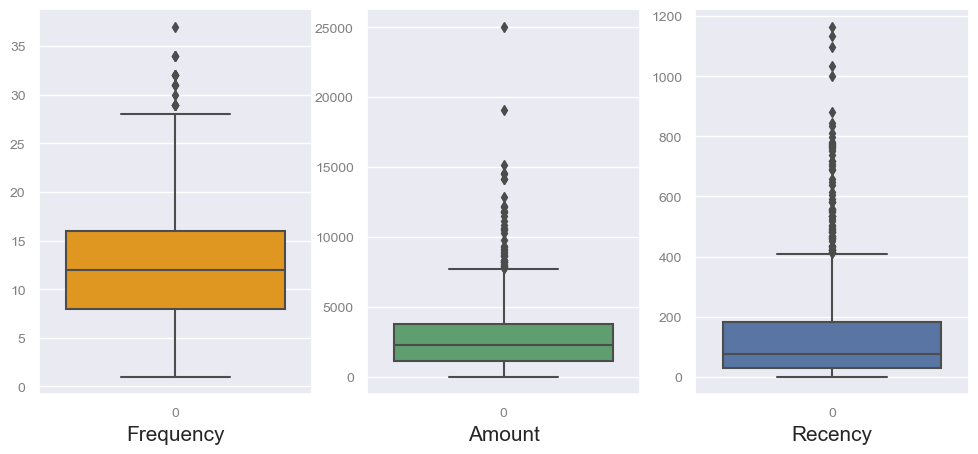

In [155]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i, col in enumerate(kdf.columns[1:]):
    sns.boxplot(data=kdf[col], ax=ax[i], color=color[i])
    ax[i].set_xlabel(col)

In [156]:
def filter_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = 1.5 * (q3 - q1)
    return data[(data > (q1 - iqr)) & (data < (q3 + iqr))]

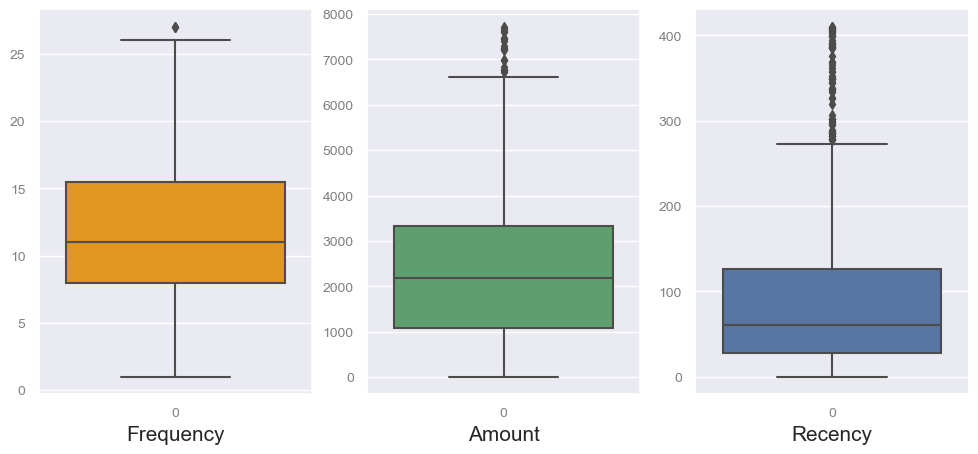

In [157]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i, col in enumerate(kdf.columns[1:]):
    sns.boxplot(data=filter_outliers(kdf[col]), ax=ax[i], color=color[i])
    ax[i].set_xlabel(col)

In [158]:
# Removing the outliers 

for col in kdf.columns[1:]:
    kdf[col] = filter_outliers(kdf[col])
    # kdf[kdf[col].isna()] = kdf[col].max()
    

In [159]:
kdf.dropna(inplace=True)

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

In [161]:
# Instantiate
scaler = StandardScaler()

# fit_transform
scaled_kdf = scaler.fit_transform(kdf[['Amount', 'Frequency', 'Recency']])
scaled_kdf.shape

scaled_kdf = pd.DataFrame(scaled_kdf)
scaled_kdf.columns = ['Amount', 'Frequency', 'Recency']
scaled_kdf.head()

,Amount,Frequency,Recency
0,1.816694,-0.252930,0.871911
1,-0.860709,0.492961,-0.814773
2,-0.424617,-0.066457,1.638585
3,1.533564,1.052379,-0.446769
4,-0.913982,-0.066457,-0.589882


In [162]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, n_init='auto')
kmeans.fit(scaled_kdf)

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 101), (1, 233), (2, 103), (3, 228)]

In [163]:
def k_cluster_analysis(data):
    ssd = []
    range_n_clusters = np.arange(2, 10)
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
        kmeans.fit(data)
        # Elbow-curve /SSD
        ssd.append(kmeans.inertia_)
        
        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    # plot the SSDs for each n_clusters
    plt.plot(ssd)

For n_clusters=2, the silhouette score is 0.34055717955067577
For n_clusters=3, the silhouette score is 0.36281641908970086
For n_clusters=4, the silhouette score is 0.3131258069813781
For n_clusters=5, the silhouette score is 0.33433067465346444
For n_clusters=6, the silhouette score is 0.2987358724775562
For n_clusters=7, the silhouette score is 0.3169815777718603
For n_clusters=8, the silhouette score is 0.27447181004043
For n_clusters=9, the silhouette score is 0.26787969845498194


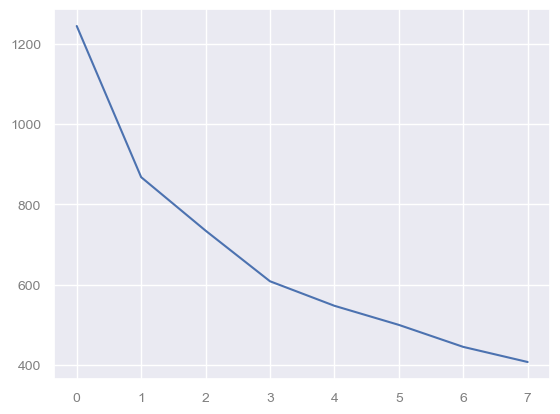

In [164]:
k_cluster_analysis(scaled_kdf)

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto')
kmeans.fit(scaled_kdf)

In [167]:
# Assign the label
kdf['Cluster ID'] = kmeans.labels_
kdf.head()

,Customer ID,Frequency,Amount,Recency,Cluster ID
0,AA-10315,11.0,5563.560,184.0,1
1,AA-10375,15.0,1056.390,19.0,0
2,AA-10480,12.0,1790.512,259.0,2
3,AA-10645,18.0,5086.935,55.0,1
7,AB-10150,12.0,966.710,41.0,0


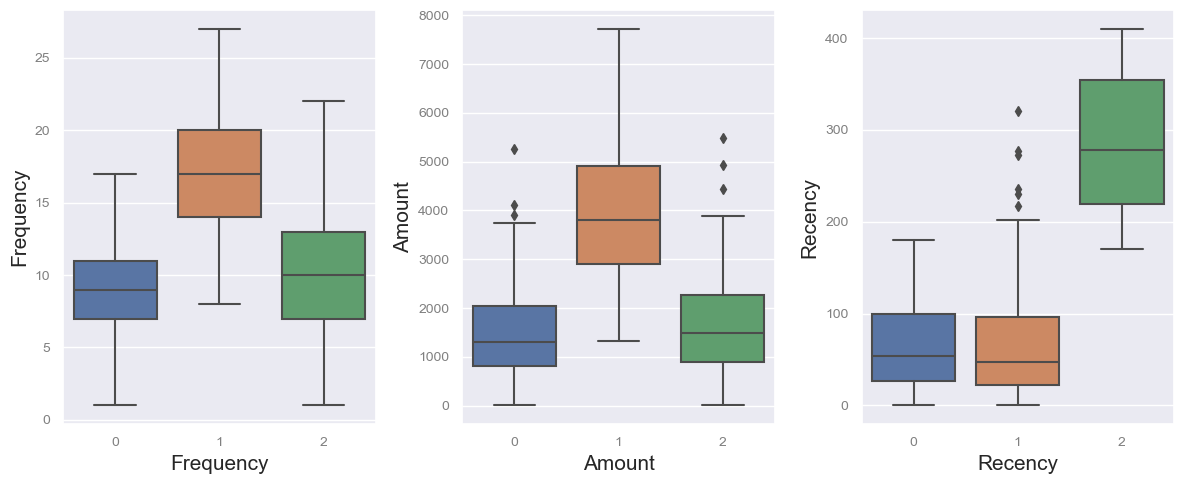

In [168]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i, col in enumerate(kdf.columns[1:4]):
    sns.boxplot(x='Cluster ID', y=col, data=kdf, ax=ax[i])
    ax[i].set_xlabel(col)
plt.tight_layout()


<Axes: xlabel='Recency', ylabel='Amount'>

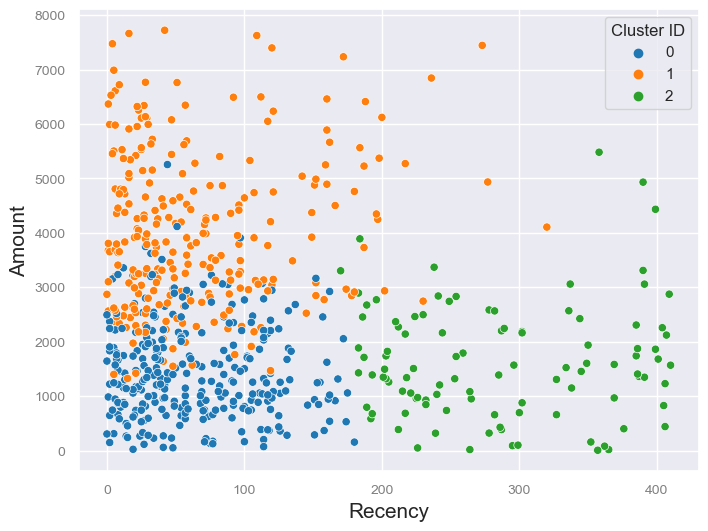

In [169]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=kdf, x='Recency', y='Amount', hue='Cluster ID', palette='tab10')